In [1]:
import pandas as pd
import time
import json
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import write_dot, graphviz_layout

In [2]:
df = pd.read_csv('/Users/emilydennis/Desktop/lightsheet/labels_updated/PRA_labels_with-graph-order_children_parents.csv')
df.head(2)

,id,name,parent_id
0,0,NaN,root
1,35,brainstem,449


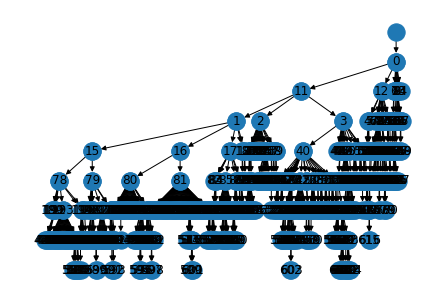

In [3]:
g = nx.DiGraph()

for index, row in df.iterrows():
    g.add_node(row.id,name=row.name)
    g.add_edge(row.parent_id,row.id)

labels = nx.get_node_attributes(g, 'name')
pos =graphviz_layout(g, prog='dot')
nx.draw(g, pos, with_labels=True,labels=labels, arrows=True)

In [4]:
def group_level_from_root(g,root,max_level):
    """ get descendants from a graph g, a root value, and a max_level
    makes a list of the descendants of root, and for each of those descendents, gets
    any further descendents up until max_level is reached. e.g. if max_level is 3,
    root is 1, root's children and grandchildren would all be included in desc"""
    desc = list(nx.descendants(g,root))
    level=1
    for child in desc:
        if str(child) in g and len(nx.descendants(g,str(child))) > 0 and level < max_level:
            for grandchild in list(nx.descendants(g,str(child))):
                if str(grandchild) in g:
                    desc.append(str(grandchild))
            level+=1
    return desc

In [5]:
def find_roots(g):
    """ in a given digraph, find the root value(s)"""
    root=[]
    for gg in g:
        if gg != 'root':
            if len(sg.in_edges(int(gg))) < 1:
                root.append(gg)
    return root

In [10]:
def get_desc_from_vals(g,vals):
    """ takes a digraph g and a list of values, and then finds all descendants of those values
    next it finds all descendants and descendants' descendants"""
    for val in vals:
        desc = list(nx.descendants(g,val))
        for dec in desc:
            if dec in g and dec != val:
                vals.append(dec)
            if str(dec) in g and dec != val:
                vals.append(str(dec))
    return vals

Text(0.5, 1.0, 'all nodes and edges')

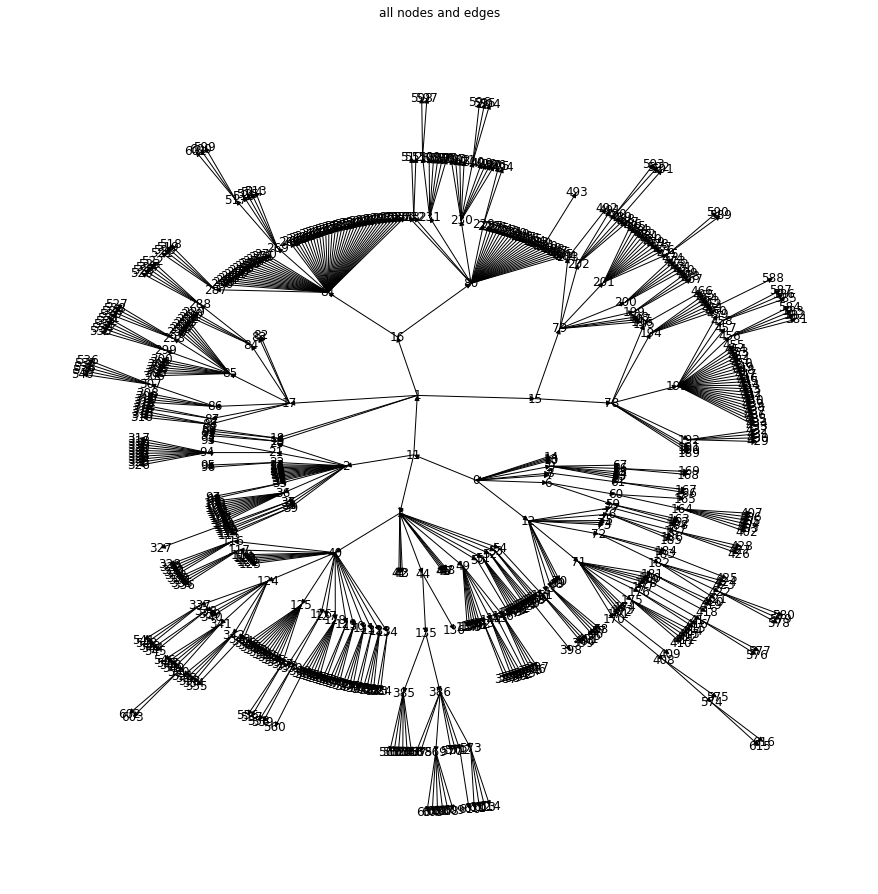

In [7]:
plt.figure(figsize=(12, 12))
labels=nx.get_node_attributes(g,'name')
pos = graphviz_layout(g, prog="twopi", args="")
nx.draw(g, pos, labels=labels,arrows=True,node_size=0)
plt.title('all nodes and edges')

In [17]:
nx.write_gexf(sg,'/Users/emilydennis/Desktop/lightsheet/pra_ingexf_subg.gexf')

In [38]:
num = 449
sg=g.copy()
vals = get_desc_from_vals(sg,group_level_from_root(sg,str(num),3))

In [40]:
badvals = []

vallist=[]
for val in vals:
    vallist.append(str(val))

for node in list(sg.nodes()):
    if str(node) not in vallist and str(node) != str(num):
        print(str(node))
        badvals.append(node)

0
root
243
450
244
443
0
444
445
446
448
450
451
452
43
53
54
55
127
128
129
184
185
186
187
188
255
59
63
64
65
66
67
398
564
565
567
570
571
573
581
617
112
244
113
114
115
572
443
616
613
445
530
446
531
532
533
534
535
154
155
156
157
158
159
251
252
569
603
91
59
92
93
94
95
96
97
98
104
105
233
234
237
238
239
240
242
597
604
34
66
563
38
567
106
107
108
109
110
111
575
576
605
62
570
68
571
69
70
71
72
73
87
573
88
89
574
181
581
182
183
588
617
85
572
86
549
616
550
499
613
500
253
534
254
116
157
117
118
119
120
121
122
123
124
125
126
596
150
158
151
152
56
569
57
58
430
603
11
91
12
13
76
77
139
92
140
141
142
192
104
193
194
195
440
579
582
583
344
105
345
346
347
348
349
350
351
352
353
354
355
356
28
233
30
551
237
552
553
554
555
556
557
463
238
464
363
239
364
365
366
378
240
379
561
562
465
242
466
23
597
24
25
26
241
604
442
60
34
61
137
111
138
99
575
100
101
102
103
576
478
605
479
480
481
90
574
259
588
260
261
78
549
79
80
81
82
83
136
116
153
117
358
121
359
360


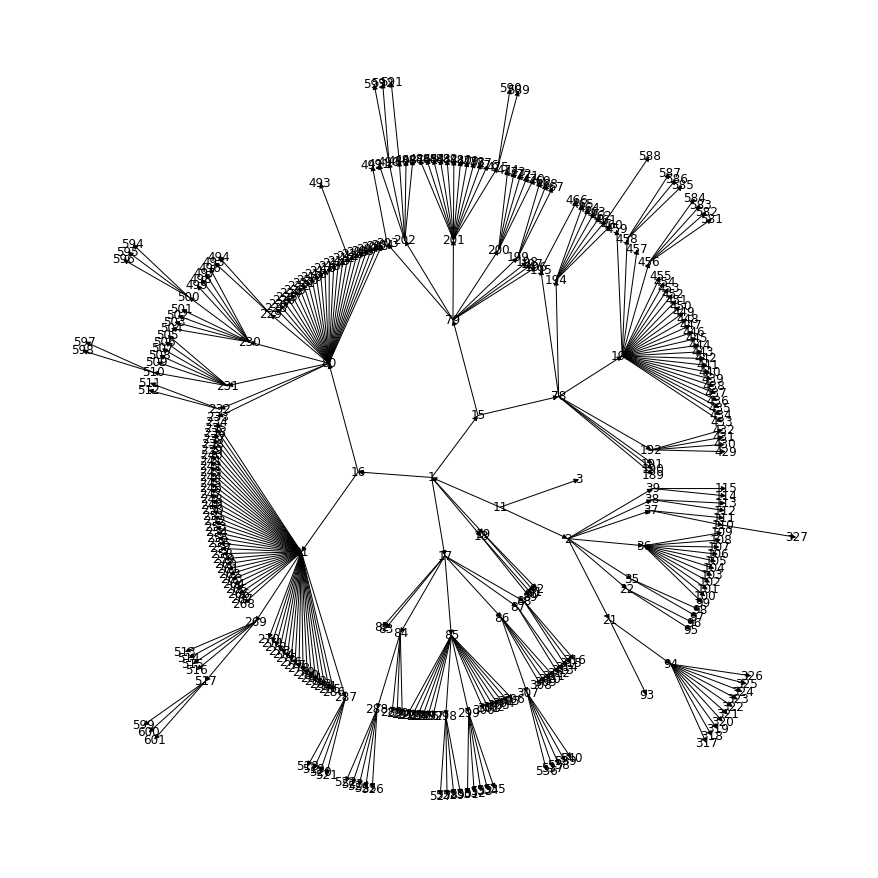

In [41]:
sg.remove_nodes_from(badvals)

plt.figure(figsize=(12, 12))
labels=nx.get_node_attributes(sg,'name')
pos = graphviz_layout(sg, prog="twopi", args="")
nx.draw(sg, pos, labels=labels, arrows=True,node_size=0)
# need to remove descend's of removed nodes. too tired, will do tomorrow

In [75]:
for i in list(g.edges()):
    if i not in list(sg.edges()):
        print(i)

('449', 35)
('449', 36)
('449', 37)
('39', 189)
('39', 190)
('40', 225)
('40', 226)
('41', 305)
('41', 306)
('41', 592)
('41', 593)
('41', 594)
('41', 611)
('41', 612)
('577', 134)
('577', 135)
('595', 340)
('595', 341)
('51', 44)
('51', 45)
('52', 46)
('52', 47)
('568', 9)
('568', 10)
('580', 170)
('580', 171)
('580', 172)
('580', 173)
('580', 174)
('580', 175)
('580', 176)
('580', 177)
('580', 178)
('580', 179)
('580', 180)
('587', 217)
('587', 218)
('609', 485)
('609', 486)
('610', 487)
('610', 488)
('189', 265)
('189', 266)
('189', 267)
('189', 589)
('189', 590)
('189', 591)
('189', 599)
('190', 405)
('190', 406)
('190', 407)
('190', 598)
('190', 600)
('190', 601)
('190', 602)
('190', 608)
('225', 20)
('225', 21)
('225', 22)
('225', 211)
('225', 212)
('225', 213)
('225', 214)
('225', 256)
('225', 377)
('225', 388)
('225', 389)
('225', 390)
('225', 391)
('225', 392)
('225', 393)
('225', 394)
('225', 395)
('225', 396)
('225', 397)
('225', 399)
('225', 400)
('225', 401)
('225', 402)
(